## Train temporal models for mortality risk prediction

## Imports

In [1]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
import random
import torch

from cyclops.processors.column_names import EVENT_NAME
from cyclops.utils.file import load_pickle
from models.temporal.optimizer import Optimizer, EarlyStopper
from models.temporal.utils import (
    get_data,
    get_device,
    get_temporal_model,
    load_checkpoint,
)

from models.temporal.metrics import print_metrics_binary
from drift_detection.gemini.utils import prep, get_use_case_params, import_dataset_hospital, random_shuffle_and_split
from drift_detection.drift_detector.plotter import plot_pretty_confusion_matrix
from drift_detection.gemini.constants import DIAGNOSIS_DICT, HOSPITALS

2023-03-20 01:21:12.779909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.1.3/lib/R/lib:/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2023-03-20 01:21:12.779980: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ImportError: libGL.so.1: cannot open shared object file: No such file or directory

In [ ]:
DIAGNOSIS_DICT

# Choose dataset and use-case

In [ ]:
DATASET = "gemini"
USE_CASE = "mortality"
DIR=os.path.join("/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini",USE_CASE,"saved_models")
ID = SPLIT = "adult_18_29"#input("Select data split: ")
DIAGNOSIS_TRAJECTORY = input("Select diagnosis trajectory to filter on: ") 
HOSPITAL = input("Select hospital to filter on: ") 

splice_map = {
    "hospital_id": HOSPITALS
}

if DIAGNOSIS_TRAJECTORY != "all":
    diagnosis_trajectory = '_'.join(DIAGNOSIS_DICT[DIAGNOSIS_TRAJECTORY])
    ID = ID +"_"+ diagnosis_trajectory
    splice_map["diagnosis_trajectory"] = [diagnosis_trajectory]
    
if HOSPITAL != "all":
    ID = HOSPITAL + "_" + ID 
    splice_map["hospital_id"] = [HOSPITAL]
    
use_case_params = get_use_case_params(DATASET, USE_CASE)

## Load train/val/test inputs and labels

In [ ]:
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

X_train_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_train_X_"+ID)
y_train_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_train_y_"+ID)
X_val_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_val_X_"+ID)
y_val_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_val_y_"+ID)
X_test_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_test_X_"+ID)
y_test_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_test_y_"+ID)

X_train = prep(X_train_vec.data)
y_train = prep(y_train_vec.data)
X_val = prep(X_val_vec.data)
y_val = prep(y_val_vec.data)
X_test = prep(X_test_vec.data)
y_test = prep(y_test_vec.data)

(X_train, y_train), (X_val, y_val) = random_shuffle_and_split(X_train, y_train, X_val, y_val)

In [ ]:
unique, train_counts = np.unique(y_train, return_counts=True)
unique, val_counts = np.unique(y_val, return_counts=True)
unique, test_counts = np.unique(y_test, return_counts=True)
print(pd.DataFrame({'Train':train_counts,'Val': val_counts, 'Test':test_counts}, index=unique))

In [114]:
output_dim = 1
batch_size = 64
input_dim = X_train.shape[2]
timesteps = X_train.shape[1]
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 128
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False
device = get_device()

In [115]:
train_dataset = get_data(X_train, y_train)
train_loader = train_dataset.to_loader(batch_size, shuffle=True)

val_dataset = get_data(X_val, y_val)
val_loader = val_dataset.to_loader(batch_size)

test_dataset = get_data(X_test, y_test)
test_loader = test_dataset.to_loader(batch_size=1, shuffle=True)

## Model and training configuration

In [116]:
model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model_name = "lstm"
model = get_temporal_model(model_name, model_params).to(device)

## Training and validation

[1/128] Training loss: 1.5382	                 Validation loss: 1.4241
[2/128] Training loss: 1.3902	                 Validation loss: 1.3614
[3/128] Training loss: 1.3452	                 Validation loss: 1.3329
[4/128] Training loss: 1.3193	                 Validation loss: 1.3136
[5/128] Training loss: 1.2977	                 Validation loss: 1.3006
[6/128] Training loss: 1.2838	                 Validation loss: 1.2897
[7/128] Training loss: 1.2747	                 Validation loss: 1.2803
[8/128] Training loss: 1.2653	                 Validation loss: 1.2726
[9/128] Training loss: 1.2584	                 Validation loss: 1.2656
[10/128] Training loss: 1.2487	                 Validation loss: 1.2604
[11/128] Training loss: 1.2436	                 Validation loss: 1.2549
[12/128] Training loss: 1.2330	                 Validation loss: 1.2502
[13/128] Training loss: 1.2296	                 Validation loss: 1.2466
[14/128] Training loss: 1.2254	                 Validation loss: 1.2432
[

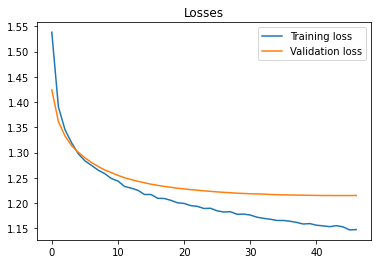

In [117]:
filepath=os.path.join(DIR,ID+"_reweight_positive"+"_"+model_name+"_"+str(seed)+".pt")
if os.path.exists(filepath):
    model, opt, n_epochs = load_checkpoint(filepath, model)
else:
    reweight_positive = (y_train == 0).sum() / (y_train == 1).sum() * 2

    loss_fn = nn.BCEWithLogitsLoss(reduction="none")
    optimizer = optim.Adagrad(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=128, gamma=0.5)
    activation = nn.Sigmoid()
    earlystopper = EarlyStopper(patience=3, min_delta=0)
    opt = Optimizer(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        activation=activation,
        lr_scheduler=lr_scheduler,
        reweight_positive=reweight_positive,
        earlystopper = earlystopper
    )
    opt.train(
         train_loader,
         val_loader,
         n_epochs=n_epochs,
    )
    opt.plot_losses()
    state = {
        'n_epochs': n_epochs,
        'model': model.state_dict(),
        'optimizer': opt
    }
    torch.save(state, filepath)
    filepath

In [118]:
filepath

'/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/saved_models/seasonal_winter_reweight_positive_lstm_1.pt'

## Validation metrics

confusion matrix:
[[34606 22976]
 [  615  4368]]
accuracy: 0.6229361295700073
precision class 0: 0.9825388193130493
precision class 1: 0.159742534160614
recall class 0: 0.6009864211082458
recall class 1: 0.8765803575515747
AUC of ROC: 0.8287881778143635
AUC of PRC: 0.32984003317357824
min(+P, Se): 0.3612281757977122
Precision: 0.5711406469345093
Recall: 0.7387833595275879


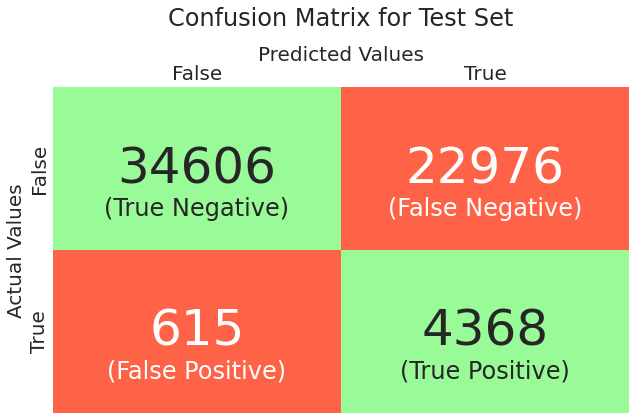

In [205]:
y_val_labels, y_val_pred_values, y_val_pred_labels = opt.evaluate(
    val_loader
)

y_val_pred_values = y_val_pred_values[y_val_labels != -1]
y_val_pred_labels = y_val_pred_labels[y_val_labels != -1]
y_val_labels = y_val_labels[y_val_labels != -1]

confusion_matrix = metrics.confusion_matrix(y_val_labels, y_val_pred_labels)

pred_metrics = print_metrics_binary(y_val_labels, y_val_pred_values, y_val_pred_labels)
prec = (pred_metrics["prec0"] + pred_metrics["prec1"]) / 2
rec = (pred_metrics["rec0"] + pred_metrics["rec1"]) / 2
print(f"Precision: {prec}")
print(f"Recall: {rec}")
    
plot_pretty_confusion_matrix(confusion_matrix)

## Testing metrics

confusion matrix:
[[115021  72846]
 [  1832  14966]]
accuracy: 0.6351208090782166
precision class 0: 0.984322190284729
precision class 1: 0.17043228447437286
recall class 0: 0.6122469902038574
recall class 1: 0.8909394145011902
AUC of ROC: 0.8426717108609918
AUC of PRC: 0.34494803520329553
min(+P, Se): 0.3754018335516133
Precision: 0.5773772597312927
Recall: 0.7515932321548462


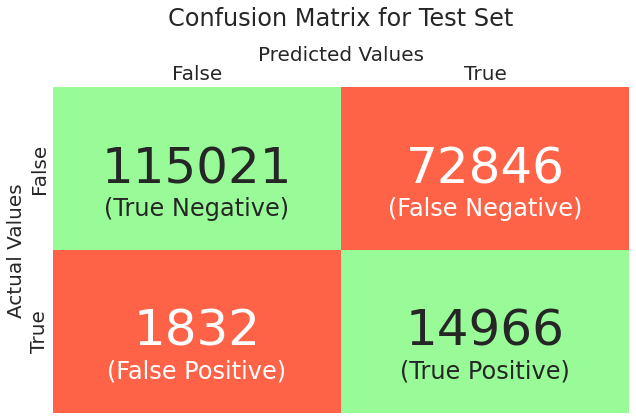

In [206]:
y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
    test_loader
)

y_pred_values = y_pred_values[y_test_labels != -1]
y_pred_labels = y_pred_labels[y_test_labels != -1]
y_test_labels = y_test_labels[y_test_labels != -1]

confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)

pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels)
prec = (pred_metrics["prec0"] + pred_metrics["prec1"]) / 2
rec = (pred_metrics["rec0"] + pred_metrics["rec1"]) / 2
print(f"Precision: {prec}")
print(f"Recall: {rec}")

plot_pretty_confusion_matrix(confusion_matrix)

## Compute AUROC across timesteps

In [ ]:
num_timesteps = y_pred_labels.shape[1]
auroc_timesteps = []
for i in range(num_timesteps):
    labels = y_test_labels[:, i]
    pred_vals = y_pred_values[:, i]
    preds = y_pred_labels[:, i]
    pred_vals = pred_vals[labels != -1]
    preds = preds[labels != -1]
    labels = labels[labels != -1]
    pred_metrics = print_metrics_binary(labels, pred_vals, preds, verbose=False)
    auroc_timesteps.append(pred_metrics["auroc"])


prediction_hours = list(range(24, 168, 24))
fig = go.Figure(
    data=[go.Bar(x=prediction_hours, y=auroc_timesteps, name="model confidence")]
)

fig.update_xaxes(tickvals=prediction_hours)
fig.update_yaxes(range=[min(auroc_timesteps) - 0.05, max(auroc_timesteps) + 0.05])

fig.update_layout(
    title="AUROC split by no. of hours after admission",
    autosize=False,
    xaxis_title="No. of hours after admission",
)
fig.show()

## WIP: Compute accuracy across lead times

In [ ]:
# BASE_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/risk_of_mortality"

# combined_events = load_dataframe(os.path.join(BASE_DATA_PATH, "combined_events"))
# timestep_end_timestamps = load_dataframe(os.path.join(BASE_DATA_PATH, "aggmeta_end_ts"))

# mortality_events = combined_events.loc[combined_events["event_name"] == "death"]

# y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
#     test_loader, batch_size=1, n_features=input_dim, timesteps=timesteps, flatten=False
# )
# train_val_test_ids = load_dataframe(os.path.join(BASE_DATA_PATH, "train_val_test_ids"))
# test_ids = train_val_test_ids["test"].dropna()

# num_timesteps = y_pred_labels.shape[1]
# acc_timesteps = []
# for timestep in range(num_timesteps):
#     labels = y_test_labels[:, timestep]
#     pred_vals = y_pred_values[:, timestep]
#     preds = y_pred_labels[:, timestep]

#     is_correct_timestep = []
#     for enc_id in test_ids:
#         timestep_end_timestamp = timestep_end_timestamps.loc[enc_id, timestep]
#         mortality_timestamp = mortality_events.loc[mortality_events["encounter_id"] == enc_id]["discharge_timestamp"]
#         lead_time = mortality_timestamp - timestep_end_timestamp
#         print(timestep_end_timestamp, mortality_timestamp)
#         if (lead_time > pd.to_timedelta(0, unit="h")).all():
#             label_ = labels[test_ids.index(enc_id)]
#             pred_ = preds[test_ids.index(enc_id)]

#             if label_ == 1:
#                 if label_ == pred_:
#                     is_correct_timestep.append(1)
#                 else:
#                     is_correct_timestep.append(0)

#     acc_timesteps.append(sum(is_correct_timestep) / len(is_correct_timestep))

## Visualize model outputs and labels

In [ ]:
def plot_risk_mortality(predictions, labels=None):
    prediction_hours = list(range(24, 168, 24))
    is_mortality = labels == 1
    after_discharge = labels == -1
    label_h = -0.2
    fig = go.Figure(
        data=[
            go.Scatter(
                mode="markers",
                x=prediction_hours,
                y=[label_h for x in prediction_hours],
                line=dict(color="Black"),
                name="low risk of mortality label",
                marker=dict(color="Green", size=20, line=dict(color="Black", width=2)),
            ),
            go.Scatter(
                mode="markers",
                x=[prediction_hours[i] for i, v in enumerate(is_mortality) if v],
                y=[label_h for _, v in enumerate(is_mortality) if v],
                line=dict(color="Red"),
                name="high risk of mortality label",
                marker=dict(color="Red", size=20, line=dict(color="Black", width=2)),
            ),
            go.Scatter(
                mode="markers",
                x=[prediction_hours[i] for i, v in enumerate(after_discharge) if v],
                y=[label_h for _, v in enumerate(after_discharge) if v],
                line=dict(color="Grey"),
                name="post discharge label",
                marker=dict(color="Grey", size=20, line=dict(color="Black", width=2)),
            ),
            go.Bar(
                x=prediction_hours,
                y=predictions,
                marker_color="Red",
                name="model confidence",
            ),
        ]
    )
    fig.update_yaxes(range=[label_h, 1])
    fig.update_xaxes(tickvals=prediction_hours)
    fig.update_xaxes(showline=True, linewidth=2, linecolor="black")

    fig.add_hline(y=0.5)

    fig.update_layout(
        title="Model output visualization",
        autosize=False,
        xaxis_title="No. of hours after admission",
        yaxis_title="Model confidence",
    )

    return fig


mortality_cases = [idx for idx, v in enumerate(y_test_labels)]
sample_idx = random.choice(mortality_cases)
fig = plot_risk_mortality(
    y_pred_values[sample_idx].squeeze(), y_test_labels[sample_idx]
)
fig.show()